## Introduction to Deep Learning Week 3: CNN Cancer Detection Kaggle Mini-Project
#### Project Overview

In this week assignment, we'll take part in the Kaggle [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection) Challenge. We'll build our deep learning model to identify metastatic tissue in histopathologic scans of lymph node sections. For this assignment, we'll focus solely on CNN (Convolutional Neural Network) models.

#### About the dataset

We will be using the Kaggle [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection) dataset. It is provided subjected to Kaggle [Competition Rules](https://www.kaggle.com/competitions/histopathologic-cancer-detection/rules#7-competition-data).


This dataset consists of:

- File train_labels.csv: provides the ground truth for the images in the train folder
- File sample_submission.csv: provides the sample of submission
- Folder train/: images for traning
- Folder test/:  images for testing

The models are evaluated on area under the ROC curve between the predicted probability and the observed target.

Summary of Tasks:
- Loading dataset
- Exploratory Data Analysis: 
    - Explore the dataset, perform data cleaning, data analysis, and image processing.
- Build and test models: 
    - Build, evaluate, and compare model's performances. 
- Conclusions: 
    - Summarize and discuss the results.

## Import Libraries & Setup

We'll be using PIL for basic image processing (croping), sklearn, and tensorflow/keras for CNN.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks, optimizers, metrics
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Check tensorflow version & GPU support
print("Tensorflow version " + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')

# Set batch size
BATCH_SIZE = 32
if len(physical_devices) > 0:
    print(physical_devices)
    BATCH_SIZE = 128
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
else:
    print("No GPU available!")

# Set random seed
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)

Tensorflow version 2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Images & lables path
CWD = os.getcwd()
BASE_DIR = CWD + '/histopathologic-cancer-detection/'
TRAIN_IMG_DIR = BASE_DIR + 'train/'
TEST_IMG_DIR = BASE_DIR + 'test/'
TRAIN_LABELS_FILENAME = BASE_DIR + 'train_labels.csv'
if not os.path.exists(TRAIN_LABELS_FILENAME) or not os.path.exists(TRAIN_IMG_DIR) or not os.path.exists(TEST_IMG_DIR):
    print("Dataset not found.")


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In this section, we'll explore the dataset, perform data cleaning, image and data analysis.

In [4]:
# Load labels
train_labels = pd.read_csv(TRAIN_LABELS_FILENAME)
print(f"Training labels shape: {train_labels.shape}")

Training labels shape: (220025, 2)


The training dataset contains 220,025 entries, each has 2 columns. 

In [5]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
# Check duplicated
print(train_labels.duplicated().sum())

0


There is no duplicated entry.

In [7]:
# Check null/missing values
train_labels.isnull().sum()

id       0
label    0
dtype: int64

There is no entry with missing/null values.

In [8]:
# Check number of classes
print("Number of distinguish classes:", train_labels['label'].nunique())
print(train_labels['label'].value_counts())

Number of distinguish classes: 2
label
0    130908
1     89117
Name: count, dtype: int64


There are 2 distingished classes. Class 0 (negative): 130,908 samples, class 1 (positive): 89,117 samples.

In [9]:
print(f'Number of training images: {len(os.listdir(TRAIN_IMG_DIR)):,d}')

# check if corresponding training images exist.
for id in train_labels['id']:
    img_filepath = os.path.join(TRAIN_IMG_DIR, id + '.tif')
    if not os.path.exists(img_filepath):
        print(f'File {img_filepath} does not exist.')
        train_labels = train_labels.drop(train_labels[train_labels['id'] == id].index)

train_labels.reset_index(inplace=True)

# check number of test images
print(f'Number of test images: {len(os.listdir(TEST_IMG_DIR)):,d}')

Number of training images: 220,025
Number of test images: 57,458


There are 220,025 training images in train folder and 57,458 test images in test folder.

### Image Format, Size and Color Channels

In [10]:
# Check image format, size and number of channels
img_path = os.path.join(TRAIN_IMG_DIR, train_labels['id'][0] + '.tif')
img = Image.open(img_path)
print('Image format:', img.format)
print('Image size (WxH):', img.size)
print('Color channels:', img.mode)
print(f'Image size (bytes): {np.array(img).nbytes:,d}')

Image format: TIFF
Image size (WxH): (96, 96)
Color channels: RGB
Image size (bytes): 27,648


### Display Image Samples

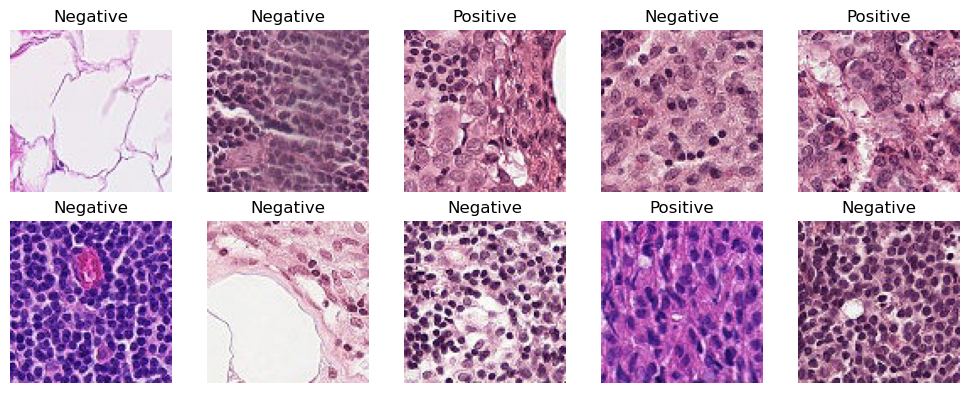

In [11]:
# Display random training images
rows = 2
cols = 5
n_samples = rows * cols
text_labels = ['Negative', 'Positive']

df_samples = train_labels.sample(n_samples)

plt.figure(figsize=(2*cols, 2*rows))

for idx, (_, row) in enumerate(df_samples.iterrows()):
    img_path = os.path.join(TRAIN_IMG_DIR, row['id'] + '.tif')
    img = plt.imread(img_path)
    plt.subplot(rows, cols, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(text_labels[row['label']])
    
plt.tight_layout()
plt.show()


### Label Distribution

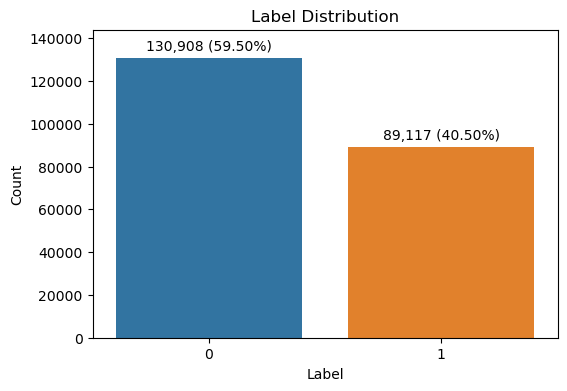

In [12]:
# Display label distribution
labels, counts = np.unique(train_labels['label'], return_counts=True)
n_labels = counts.sum()
plt.figure(figsize=(6,4))
ax = sns.countplot(data=train_labels, x='label', hue='label', legend=None)
for p in ax.patches:
    count = p.get_height()
    percent = 100 * count / n_labels
    ptitle = f'{count:,.0f} ({percent:.2f}%)'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + n_labels/100, ptitle, ha='center', va='bottom', fontsize=10)
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.ylim(0, counts.max() * 1.1)
plt.show()

Class 0 (Negative) consists of 130,908 samples or 59.5%, class 1 (Positive) consists of 89,117 samples or 40.5%. The dataset is slighly imbalanced

### Prepare Data for Training, Validation & Test

Now we'll prepare data for training and validation and test our models. We'll load the images into memory, take the center 32x32px region of the images, and normalize image data (divide by 255).

#### Load Images

In [13]:
# load image, take the center 32x32px region and convert to np.array
def process_image(image_path):
    img = Image.open(image_path)
    w, h = img.size
    new_w, new_h = 32, 32
    left = (w - new_w)//2
    right = left + new_w
    top = (h - new_h)//2
    bottom = top + new_h
    cropped_img = img.crop((left,top,right,bottom))
    return np.array(cropped_img)/255.0

# Load and process images
def load_images(ids, directory, image_shape=(32, 32, 3), dtype='float16'):
    data = np.zeros((len(ids), image_shape[0], image_shape[1], image_shape[2]), dtype=dtype)
    for i, id in enumerate(ids):
        image_path = os.path.join(directory, id + '.tif')
        data[i] = process_image(image_path)
    return data

# Loading train images
n_images = len(train_labels)
print(f'Loading {n_images} training images... ', end='')
train_data = load_images(train_labels['id'].values, TRAIN_IMG_DIR)
print('done')

# Loading test images
testids = [id.split('.')[0] for id in os.listdir(TEST_IMG_DIR) if id.endswith('.tif')]
n_images = len(testids)
print(f'Loading {n_images} test images... ', end='')
test_data = load_images(testids, TEST_IMG_DIR)
print('done')

# check data shape
print("Training image data shape: ", train_data.shape)
print("Test image data shape: ", test_data.shape)

Loading 220025 training images... done
Loading 57458 test images... done
Training image data shape:  (220025, 32, 32, 3)
Test image data shape:  (57458, 32, 32, 3)


#### Split into Train & Validation

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    train_data,
    train_labels, 
    test_size=0.25,
    random_state=42, 
    stratify=train_labels['label'])

y_train = y_train['label'].values
y_val = y_val['label'].values

# Display shapes
print('Training data shape: ', X_train.shape, y_train.shape)
print('Validation data shape: ', X_val.shape, y_val.shape)

Training data shape:  (165018, 32, 32, 3) (165018,)
Validation data shape:  (55007, 32, 32, 3) (55007,)


## Models

In [15]:
# Build CNN model
def build_model(name, filters, units, input_shape=(32,32,3), batchnorm=False, l2=False, dropout_rate=0.0):
    model = models.Sequential(name=name)
    # Input layer
    model.add(layers.Input(shape=input_shape))
    # Convolutinal layers
    for filter in filters:
        model.add(layers.Conv2D(filter, (3, 3), padding='same', activation='relu'))
        if batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))
    # Flatten
    model.add(layers.Flatten())
    # Dense layers
    for unit in units:
        if l2:
            model.add(layers.Dense(unit, activation='relu', kernel_regularizer='l2'))
        else:
            model.add(layers.Dense(unit, activation='relu'))
        if batchnorm:
            model.add(layers.BatchNormalization())
        if dropout_rate>0:
            model.add(layers.Dropout(dropout_rate))
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Compile & fit
def compile_and_fit(model, X_train, y_train, X_val, y_val, num_epochs, batch_size, verbose=1):
    # Setup callbacks
    model_cbs = [
        # Stop training if performance doesn't improve
        callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=5, 
            restore_best_weights=True, 
            verbose=verbose
        ),
        # Reduce learning rate on plateau
        callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            patience=5, 
            factor=0.2, 
            min_lr=1e-6,
            verbose=verbose
        ),
        # Save best model
        callbacks.ModelCheckpoint(
            filepath=f'{model.name}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=verbose
        )
    ]
    
    # Complie model
    model.compile(
        optimizer=optimizers.Adam(), 
        loss='binary_crossentropy', 
        metrics=['accuracy', metrics.AUC(name='auc')]
    )

    # Fit model
    history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val), 
        epochs=num_epochs,
        callbacks=model_cbs, 
        batch_size=batch_size, 
        verbose=verbose
    )
    return history

# Plot model traning history & validation results
def plot_model_result(model, training_history, X_val, y_val):
    rows = 1
    if X_val is not None:
        y_val_prob = model.predict(X_val, verbose=0)
        y_val_pred = (y_val_prob > 0.5).astype(int).flatten()
        model_hist = training_history.history
        epochs = [epoch+1 for epoch in training_history.epoch]
        rows = 2

    plt.figure(figsize=(9, rows*3))

    # Loss plot
    plt.subplot(rows, 2, 1)
    plt.plot(epochs, model_hist['loss'], label='Train Loss')
    plt.plot(epochs, model_hist['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(loc='lower left')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(rows, 2, 2)
    plt.plot(epochs, model_hist['accuracy'], label='Train Accuracy')
    plt.plot(epochs, model_hist['val_accuracy'], label='Val Accuracy')
    #plt.ylim(0.5,1.05)
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend(loc='lower right')
    plt.legend()

    if X_val is not None:
        # ROC curve plot
        fpr, tpr, _ = roc_curve(y_val, y_val_prob)
        roc_auc = auc(fpr, tpr)
        plt.subplot(rows, 2, 3)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:0.3f})')
        plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title(f"Model ROC Curve")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        #plt.legend(loc='lower right')
        plt.legend()

        # Confusion matrix plot
        plt.subplot(rows, 2, 4)
        cm = confusion_matrix(y_val, y_val_pred)
        ax = sns.heatmap(
            cm, 
            annot=True, 
            fmt='d', 
            cmap=plt.cm.Blues,
            xticklabels=labels,
            yticklabels=labels
        )
        plt.title(f'Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        ax.xaxis.tick_top()

    plt.tight_layout()
    plt.show()

# Create Kaggle submission
def create_submission(model, X_test, batch_size, print_samples=True):
    # Create submission
    y_test_prob = model.predict(X_test, batch_size=batch_size, verbose=1)
    y_test_pred = (y_test_prob > 0.5).astype(int).flatten()
    submission_df = pd.DataFrame({'id': testids,'label': y_test_pred})
    filename = 'submission-' + model.name + '.csv'
    submission_df.to_csv(filename, index=False)
    # Print submission samples
    if print_samples:
        print(f"\nSubmission file: {filename}\n")
        print(f"Sample of submission content:\n{submission_df.head()}")

### Simple ANN Model

In [16]:
# Create baseline CNN model
ann_model = build_model('ann_model', [], [256])
print("Simple ANN Model Summary:")
ann_model.summary()

2025-06-17 11:06:24.748278: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-17 11:06:24.749142: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-17 11:06:24.749682: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1750133184.750117 14322281 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1750133184.751074 14322281 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Simple ANN Model Summary:


Model: "ann_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 786,945 (3.00 MB)

 Trainable params: 786,945 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

#### ANN Model - Training

In [17]:
# Train model
ann_model_history = compile_and_fit(ann_model, X_train, y_train, X_val, y_val, 20, BATCH_SIZE, verbose=1)

Epoch 1/20


2025-06-17 11:06:32.798230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
E0000 00:00:1750133192.804436 14322281 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1290/1290 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5933 - auc: 0.6055 - loss: 0.9801
Epoch 1: val_accuracy improved from -inf to 0.63559, saving model to ann_model.keras
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5933 - auc: 0.6055 - loss: 0.9799 - val_accuracy: 0.6356 - val_auc: 0.6866 - val_loss: 0.6241 - learning_rate: 0.0010
Epoch 2/20
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6400 - auc: 0.6860 - loss: 0.6181
Epoch 2: val_accuracy did not improve from 0.63559
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6400 - auc: 0.6861 - loss: 0.6181 - val_accuracy: 0.6274 - val_auc: 0.7177 - val_loss: 0.6026 - learning_rate: 0.0010
Epoch 3/20
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6572 - auc: 0.7113 - loss: 0.6012
Epoch 3: val_accuracy did not improve from 0.63559
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - accuracy: 0.6572 - auc: 0.7113 - loss: 0.6012 - val_accuracy: 0.6263 - val_auc: 0.7321 - val_loss: 0.5956 - learni

#### ANN Model - Training Results and Analysis

E0000 00:00:1750133908.361694 14322281 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


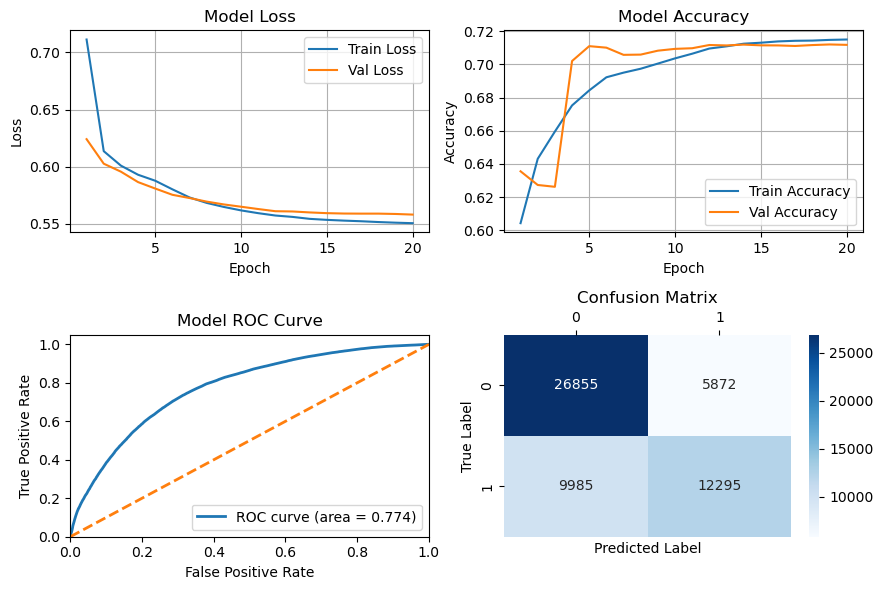

In [18]:
# Plot model results
plot_model_result(ann_model, ann_model_history, X_val, y_val)

From above graph, we can see that the model is very slow to coverage. The ROC curve plot shows that the area under curve (AUC) is 0.774. The confusion matrix plot shows that there are many false positive cases due to misclassification. Our model failed to classify 5.872 out of 32.727 negative (0) cases or 17.94% and it failed to to classify 9.985 out of 22.280 positive (1) cases or 44.82%.

#### ANN Model - Submission & Test Result

In [19]:
create_submission(ann_model, test_data, batch_size=BATCH_SIZE)

449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Submission file: submission-ann_model.csv

Sample of submission content:
                                         id  label
0  fd0a060ef9c30c9a83f6b4bfb568db74b099154d      1
1  1f9ee06f06d329eb7902a2e03ab3835dd0484581      1
2  19709bec800f372d0b1d085da6933dd3ef108846      1
3  7a34fc34523063f13f0617f7518a0330f6187bd3      0
4  93be720ca2b95fe2126cf2e1ed752bd759e9b0ed      0


Kaggle public score: By submitting this file to Kaggle, we got the public score of 0.7395

### Baseline CNN - Model Architecture

In [20]:
# Create baseline CNN model
basemodel = build_model('baseline-cnn', [64, 128, 256], [256])
print("Baseline CNN Model Summary:")
basemodel.summary()

Baseline CNN Model Summary:


Model: "baseline-cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,419,905 (5.42 MB)

 Trainable params: 1,419,905 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

#### Baseline CNN Model - Training

In [21]:
# Train model
basemodel_history = compile_and_fit(basemodel, X_train, y_train, X_val, y_val, 20, BATCH_SIZE, verbose=1)

Epoch 1/20
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7449 - auc: 0.8026 - loss: 0.5222

E0000 00:00:1750134022.662468 14322281 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 1: val_accuracy improved from -inf to 0.79241, saving model to baseline-cnn.keras
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 94s 70ms/step - accuracy: 0.7450 - auc: 0.8026 - loss: 0.5222 - val_accuracy: 0.7924 - val_auc: 0.8554 - val_loss: 0.4596 - learning_rate: 0.0010
Epoch 2/20
1289/1290 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7986 - auc: 0.8657 - loss: 0.4442
Epoch 2: val_accuracy improved from 0.79241 to 0.81066, saving model to baseline-cnn.keras
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 85s 66ms/step - accuracy: 0.7987 - auc: 0.8657 - loss: 0.4442 - val_accuracy: 0.8107 - val_auc: 0.8827 - val_loss: 0.4247 - learning_rate: 0.0010
Epoch 3/20
1289/1290 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8138 - auc: 0.8826 - loss: 0.4174
Epoch 3: val_accuracy improved from 0.81066 to 0.81795, saving model to baseline-cnn.keras
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 1347s 1s/step - accuracy: 0.8138 - auc: 0.8826 - loss: 0.4174 - val_accuracy: 0.8180 - val_auc: 0.8881 - val_loss: 0.4101 - learning_rate: 0

#### Baseline CNN Model - Training Results and Analysis

E0000 00:00:1750138826.024528 14322281 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


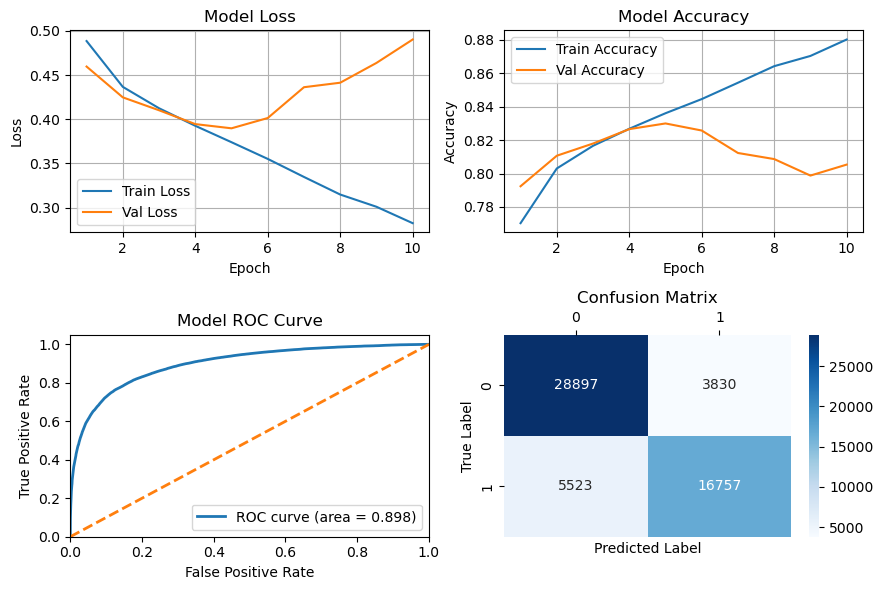

In [22]:
# Plot model results
plot_model_result(basemodel, basemodel_history, X_val, y_val)

From above graph, we can see that there is a big gap between traning and validation loss/accuracy. While the training loss continues to decrease, the validation loss starts to increase significantly after the end of 5th epoch. Likewise, the validation accuracy drops significantly after 5 epochs. This might indicate that our model is overfit. The ROC curve plot shows that the area under curve (AUC) is 0.898. Our model failed to classify 3.830 out of 32.727 negative (0) cases or 11.7% and it failed to to classify 5.523 out of 22.280 positive (1) cases or 24.78%.

#### Baseline CNN Model - Submission & Test Result

In [23]:
create_submission(basemodel, test_data, batch_size=BATCH_SIZE)

449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step

Submission file: submission-baseline-cnn.csv

Sample of submission content:
                                         id  label
0  fd0a060ef9c30c9a83f6b4bfb568db74b099154d      1
1  1f9ee06f06d329eb7902a2e03ab3835dd0484581      1
2  19709bec800f372d0b1d085da6933dd3ef108846      0
3  7a34fc34523063f13f0617f7518a0330f6187bd3      1
4  93be720ca2b95fe2126cf2e1ed752bd759e9b0ed      0


Kaggle public score: 0.8024

### Hyperparameter Tuning

In [24]:
import keras_tuner as kt

def model_builder(hp):
   
   model = build_model(
      name='cnn-hypermodel',
      filters=[64, 128, 256],
      units=[256],
      batchnorm=hp.Boolean('batchnorm'),
      l2=hp.Boolean('l2_regularizer'), 
      dropout_rate=hp.Choice('dropout_rate', [0.0, 0.5]))

   # Compile model
   model.compile(
      optimizer=optimizers.Adam(),
      loss='binary_crossentropy',
      metrics=['accuracy', metrics.AUC(name='auc')])
   return model

tuner = kt.GridSearch(hypermodel=model_builder, objective="val_accuracy")

# Setup callbacks
tuner_callbacks = [
   # Stop training if performance doesn't improve
   callbacks.EarlyStopping(
      monitor='val_loss', 
      patience=5, 
      restore_best_weights=True, 
      verbose=1
   ),
   # Reduce learning rate on plateau
   callbacks.ReduceLROnPlateau(
      monitor='val_loss', 
      patience=5, 
      factor=0.2, 
      min_lr=1e-6,
      verbose=1
   ),
   # Save best model
   callbacks.ModelCheckpoint(
      filepath=f'cnn-tuner.keras',
      monitor='val_accuracy',
      save_best_only=True,
      verbose=1
   )
]
# Search for best model
tuner.search(
   X_train, y_train, validation_data=(X_val, y_val), epochs=20, 
   callbacks=tuner_callbacks, batch_size=BATCH_SIZE, verbose=1
)

Trial 8 Complete [00h 15m 38s]
val_accuracy: 0.7956078052520752

Best val_accuracy So Far: 0.8394931554794312
Total elapsed time: 02h 57m 45s


In [25]:
# Display top 3 best models
tuner.results_summary(3)

Results summary
Results in ./untitled_project
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 0002 summary
Hyperparameters:
batchnorm: False
l2_regularizer: True
dropout_rate: 0.0
Score: 0.8394931554794312

Trial 0005 summary
Hyperparameters:
batchnorm: True
l2_regularizer: False
dropout_rate: 0.5
Score: 0.8393113613128662

Trial 0003 summary
Hyperparameters:
batchnorm: False
l2_regularizer: True
dropout_rate: 0.5
Score: 0.8383660316467285


In [26]:
# Retrieve best model
best_hp = tuner.get_best_hyperparameters()[0]
hypermodel = tuner.hypermodel.build(best_hp)
hypermodel.summary()

Model: "cnn-hypermodel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,419,905 (5.42 MB)

 Trainable params: 1,419,905 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
## Retrain best model
hypermodel_history = hypermodel.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=20, 
    callbacks=tuner_callbacks, batch_size=BATCH_SIZE, verbose=1
)

Epoch 1/20


E0000 00:00:1750149526.579077 14322281 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1290/1290 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7417 - auc: 0.7996 - loss: 0.7720

E0000 00:00:1750149598.350938 14322281 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 1: val_accuracy improved from -inf to 0.78661, saving model to cnn-tuner.keras
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.7417 - auc: 0.7996 - loss: 0.7718 - val_accuracy: 0.7866 - val_auc: 0.8534 - val_loss: 0.4726 - learning_rate: 0.0010
Epoch 2/20
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7950 - auc: 0.8567 - loss: 0.4639
Epoch 2: val_accuracy improved from 0.78661 to 0.80615, saving model to cnn-tuner.keras
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 72s 56ms/step - accuracy: 0.7950 - auc: 0.8567 - loss: 0.4638 - val_accuracy: 0.8062 - val_auc: 0.8696 - val_loss: 0.4457 - learning_rate: 0.0010
Epoch 3/20
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8067 - auc: 0.8712 - loss: 0.4416
Epoch 3: val_accuracy improved from 0.80615 to 0.81333, saving model to cnn-tuner.keras
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 77s 60ms/step - accuracy: 0.8067 - auc: 0.8712 - loss: 0.4416 - val_accuracy: 0.8133 - val_auc: 0.8801 - val_loss: 0.4279 - learning_rate: 0.0010
E

E0000 00:00:1750150900.601100 14322281 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


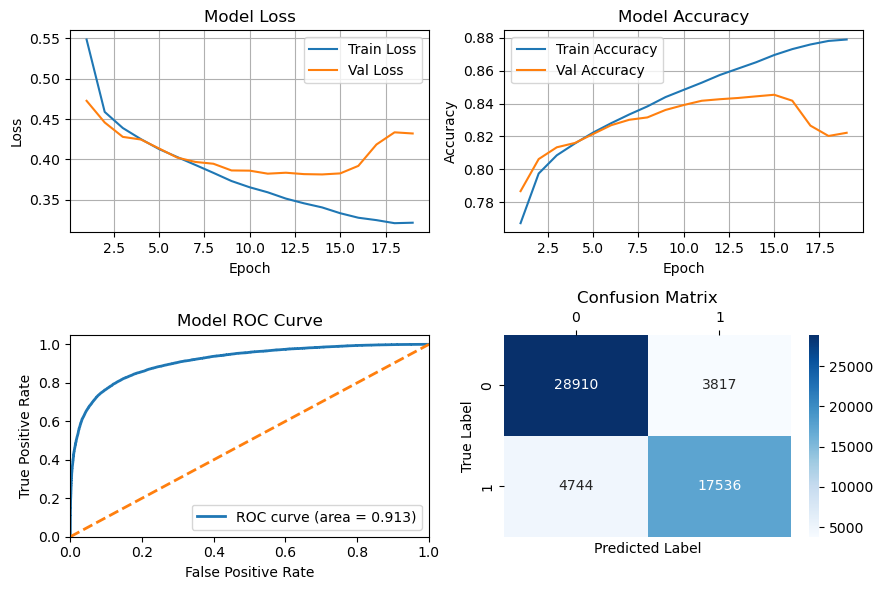

In [28]:
# Plot model results
plot_model_result(hypermodel, hypermodel_history, X_val, y_val)

From above graph, we can see that the training and validation loss/accuracy are much better. The ROC curve plot shows that the area under curve (AUC) is slightly improved from 0.898 to 0.913. Our model failed to classify 3.817 out of 32.727 negative (0) cases or 11.66% and it failed to to classify 4.744 out of 22.280 positive (1) cases or 21.29%.

In [29]:
# Create Kaggle submission
create_submission(hypermodel, test_data, batch_size=BATCH_SIZE)

449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step

Submission file: submission-cnn-hypermodel.csv

Sample of submission content:
                                         id  label
0  fd0a060ef9c30c9a83f6b4bfb568db74b099154d      1
1  1f9ee06f06d329eb7902a2e03ab3835dd0484581      1
2  19709bec800f372d0b1d085da6933dd3ef108846      1
3  7a34fc34523063f13f0617f7518a0330f6187bd3      1
4  93be720ca2b95fe2126cf2e1ed752bd759e9b0ed      0


Kaggle public score: 0.8065

### Performance Comparison

In [34]:
metrics = ['Val Loss', 'Val Accuracy', 'Val AUC', 'Public Test Score']
models_hist = [ann_model_history, basemodel_history, hypermodel_history]

# Kaggle public scores
public_test_scores = [0.7395, 0.8024, 0.8065]

performance_df = pd.DataFrame({
    'Model': ['ANN', 'Baseline CNN', 'Tuning CNN'],
    'Training Epoch': [len(history.epoch) for history in models_hist],
    'Val Loss': [np.min(history.history['val_loss']) for history in models_hist],
    'Val Accuracy': [np.max(history.history['val_accuracy']) for history in models_hist],
    'Val AUC': [np.max(history.history['val_auc']) for history in models_hist],
    'Public Test Score': [score for score in public_test_scores]
})

performance_df

,Model,Training Epoch,Val Loss,Val Accuracy,Val AUC,Public Test Score
0,ANN,20,0.558084,0.711964,0.774088,0.7395
1,Baseline CNN,10,0.389697,0.829967,0.897733,0.8024
2,Tuning CNN,19,0.381272,0.845329,0.915350,0.8065


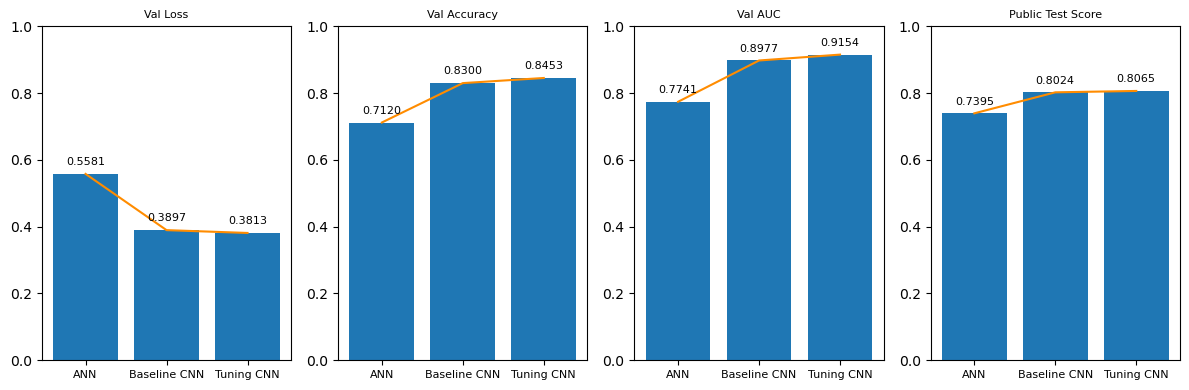

In [36]:
# Plot model comparisions
plt.figure(figsize=(12, 4))

for i, metric in enumerate(metrics):
    plt.subplot(1, 4, i+1)
    ax = plt.bar(performance_df['Model'].values, performance_df[metric])
    for p in ax.patches:
        count = p.get_height()
        ptitle = f'{count:,.04f}'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        plt.text(x, y + 0.02, ptitle, ha='center', va='bottom', fontsize=8)
    plt.plot(performance_df[metric], color='darkorange')
    plt.title(metric, fontsize=8)
    plt.xticks(fontsize=8)
    plt.ylim(0,1)
    
plt.tight_layout()
plt.show()


## Summary

In this project, we explored the Histopathologic Cancer dataset. We built our deep learning models to detect metastatic tissue in histopathologic scans of lymph node sections. We started with a simple ANN model, then we tried with a simple CNN model that consists of a few convolutional and dense layers. Finally we used keras_tuner to search for the optimal model by tuning the model's architecture and hyperparameters including: Batch Normalization, Dropout rates, and L2 regularizer.

Learnings and takeaways:

From the results, we see that convolutional neural networks (CNN) work much better than basic atificial neural networks (ANN) models. We were able to improve the test score from 0.7395 to 0.8024 by adding a few convolutional layers to the basic ANN model. Tuning model hyperparameters can further improve the model performance. Applying techniques such as early stopping can help shorten training time. Even our best model still misclassifies 11.66% of negative cases and 21.29% of positive cases, it is still far from acceptable for use in cancer diagnosis through imaging.

Further improvements: 

Here are things I would like to try:

- Data Augmentation: By generating more images from our training dataset, this can help the model generalize better to variations in real-world data.
- Deeper Networks: In this project, we tried with very simple CNN with just 3 convolutional layers. Deeper networks can learn more complex features.
- Transfer Learning: Using pre-trained Models such as ResNet, InceptionNet/GoogLeNet...
- Try another optimizers such as RMSprop, Adagrad...


